# 1. Modelos Hierárquicos Lineares de Dois Níveis (HLM2)

In [1]:
# Importação dos pacotes necessários

import pandas as pd #manipulação de dados em formato de dataframe
import seaborn as sns #biblioteca de visualização de informações estatísticas
import matplotlib.pyplot as plt #biblioteca de visualização de dados
import statsmodels.api as sm #biblioteca de modelagem estatística
from scipy import stats #estatística chi2
# !pip install -q pymer4
from pymer4.models import Lmer #estimação de modelos HLM3 neste código
from statstests.process import stepwise #procedimento Stepwise
import numpy as np

## 1.1. Base de dados e análises preliminares

In [2]:
# Carregamento da base de dados 'desempenho_aluno_escola'
df = pd.read_csv('desempenho_aluno_escola.csv', delimiter=',')

# Visualização da base de dados 'desempenho_aluno_escola'
df




,estudante,escola,desempenho,horas,texp
0,1,1,25.0,11,3.6
1,2,1,52.0,23,3.6
2,3,1,52.0,25,3.6
3,4,1,30.0,14,3.6
4,5,1,51.0,24,3.6
...,...,...,...,...,...
353,354,10,46.5,28,3.9
354,355,10,21.0,9,3.9
355,356,10,42.0,27,3.9
356,357,10,14.0,7,3.9


In [3]:
# Atribuição de categorias para as variáveis 'estudante' e 'escola'
df['estudante'] = df['estudante'].astype('category')
df['escola'] = df['escola'].astype('category')

# Características das variáveis do dataset
df.info()

# Estatísticas univariadas
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358 entries, 0 to 357
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   estudante   358 non-null    category
 1   escola      358 non-null    category
 2   desempenho  358 non-null    float64 
 3   horas       358 non-null    int64   
 4   texp        358 non-null    float64 
dtypes: category(2), float64(2), int64(1)
memory usage: 20.8 KB


,desempenho,horas,texp
count,358.000000,358.000000,358.000000
mean,41.554190,18.997207,5.161173
std,23.225896,6.368910,3.682676
min,6.500000,4.000000,1.900000
25%,21.000000,14.000000,1.900000
50%,35.500000,20.000000,3.600000
75%,59.000000,24.000000,7.500000
max,100.000000,31.000000,13.000000


In [4]:
# Estudo sobre o desbalanceamento dos dados por escola
df.groupby('escola')['estudante'].count().reset_index()

,escola,estudante
0,1,47
1,2,25
2,3,48
3,4,20
4,5,48
5,6,30
6,7,28
7,8,35
8,9,44
9,10,33


In [5]:
# Desempenho médio dos estudantes por escola
desempenho_medio = df.groupby('escola')['desempenho'].mean().reset_index()
desempenho_medio


,escola,desempenho
0,1,36.765957
1,2,21.400000
2,3,67.125000
3,4,55.325000
4,5,19.270833
5,6,33.966667
6,7,57.532143
7,8,75.428571
8,9,18.556818
9,10,38.590909


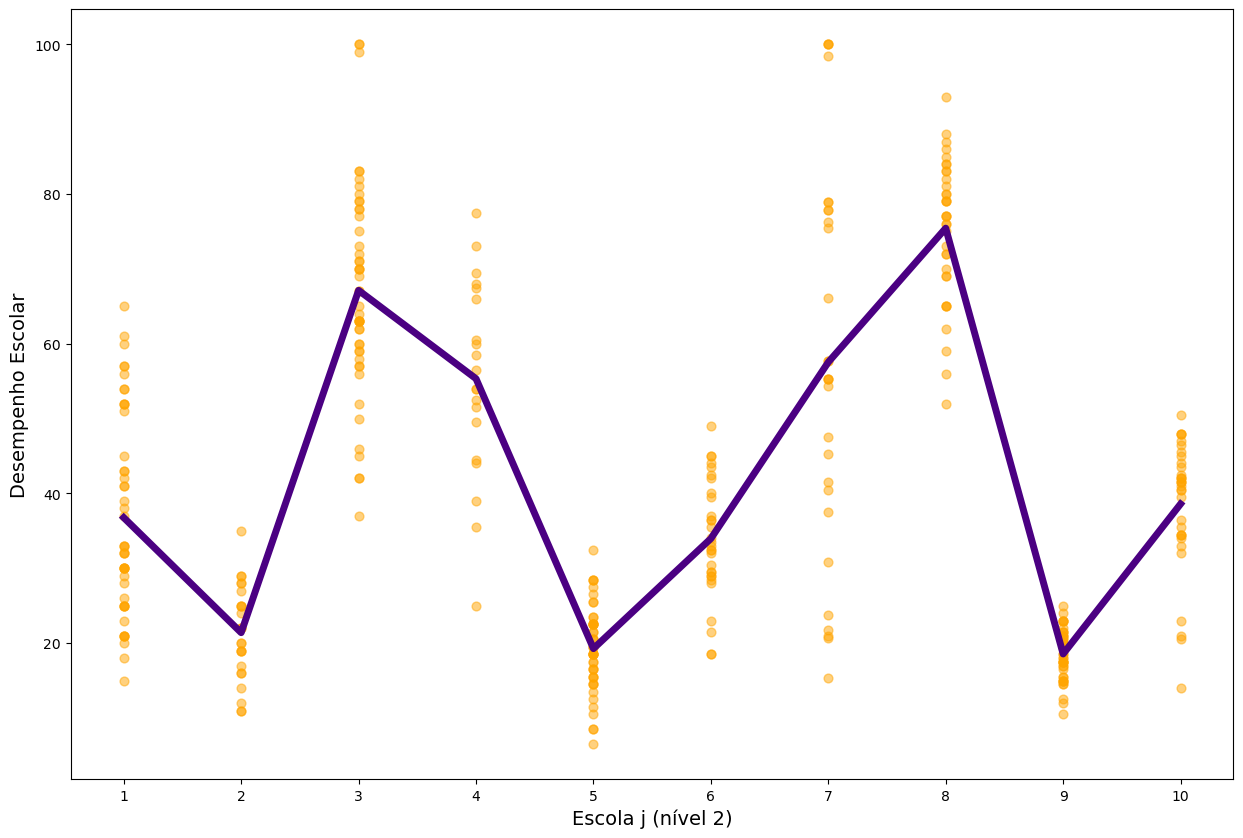

In [6]:
# Gráfico do desempenho escolar médio dos estudantes por escola

plt.figure(figsize=(15,10))
plt.plot(desempenho_medio['escola'], desempenho_medio['desempenho'],
         linewidth=5, color='indigo')
plt.scatter(df['escola'], df['desempenho'],
            alpha=0.5, color='orange', s = 40)
plt.xlabel('Escola j (nível 2)', fontsize=14)
plt.ylabel('Desempenho Escolar', fontsize=14)
plt.xticks(desempenho_medio.escola)
plt.show()

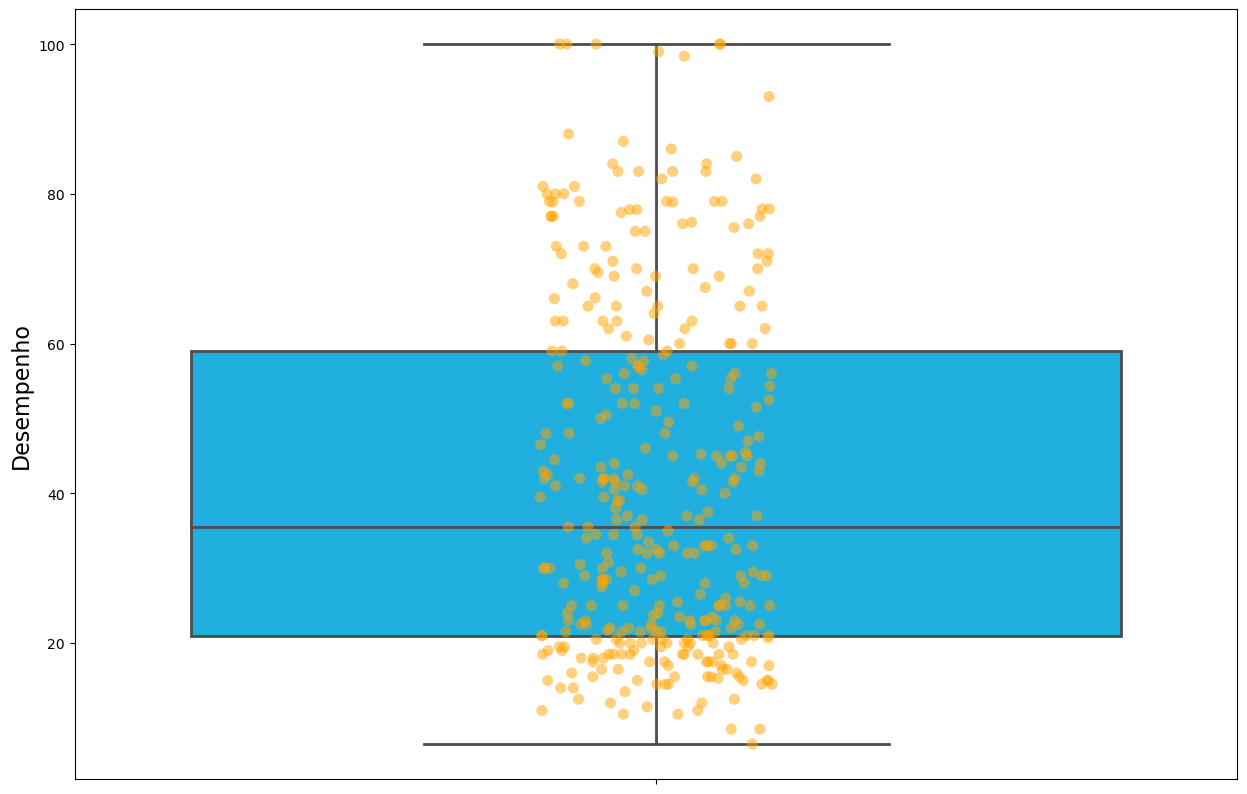

In [7]:
# Boxplot da variável dependente ('desempenho')

plt.figure(figsize=(15,10))
sns.boxplot(data=df, y='desempenho',
            linewidth=2, orient='v', color='deepskyblue')
sns.stripplot(data=df, y='desempenho',
              color='orange', jitter=0.1, size=8, alpha=0.5)
plt.ylabel('Desempenho', fontsize=16)
plt.show()

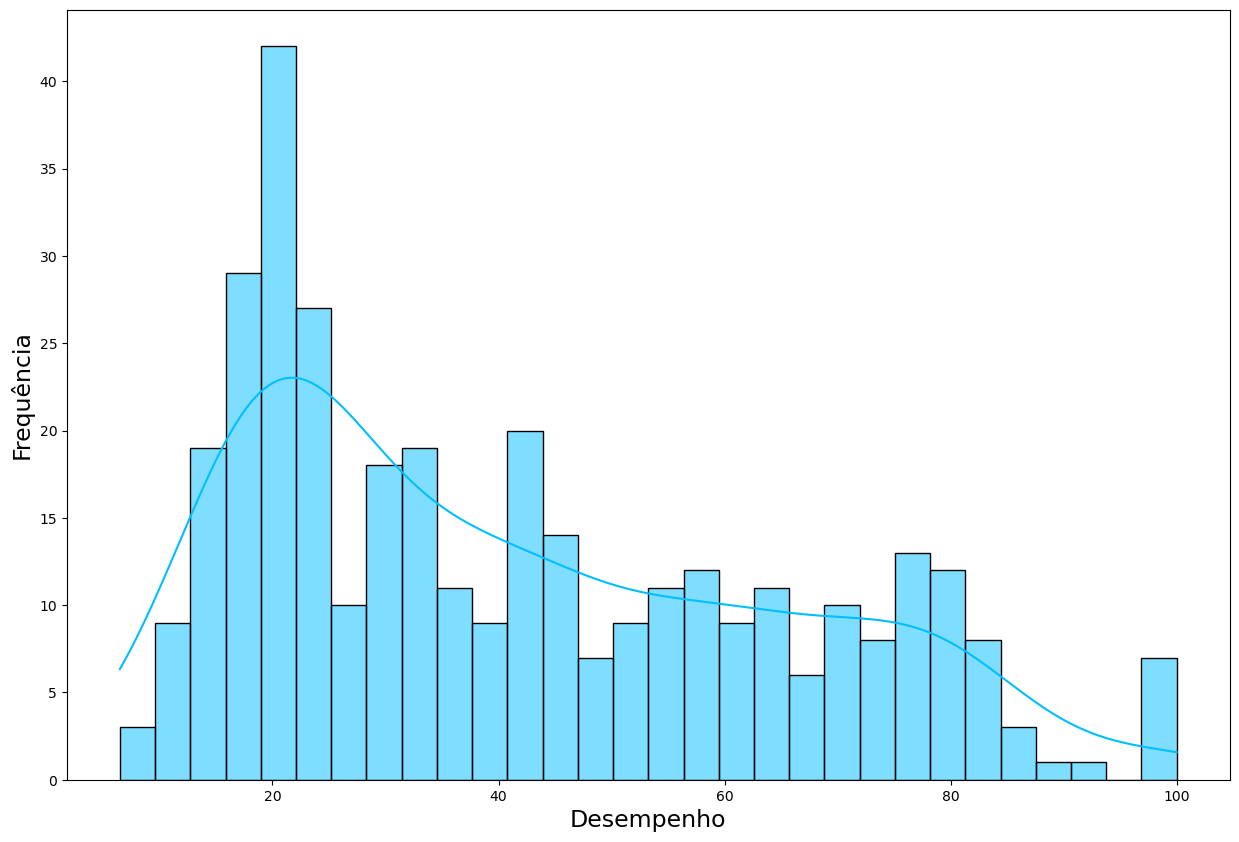

In [8]:
# Kernel density estimation (KDE) - função densidade de probabilidade da
#variável dependente ('desempenho'), com histograma

plt.figure(figsize=(15,10))
sns.histplot(data=df['desempenho'], kde=True,
             bins=30, color='deepskyblue')
plt.xlabel('Desempenho', fontsize=17)
plt.ylabel('Frequência', fontsize=17)
plt.show()

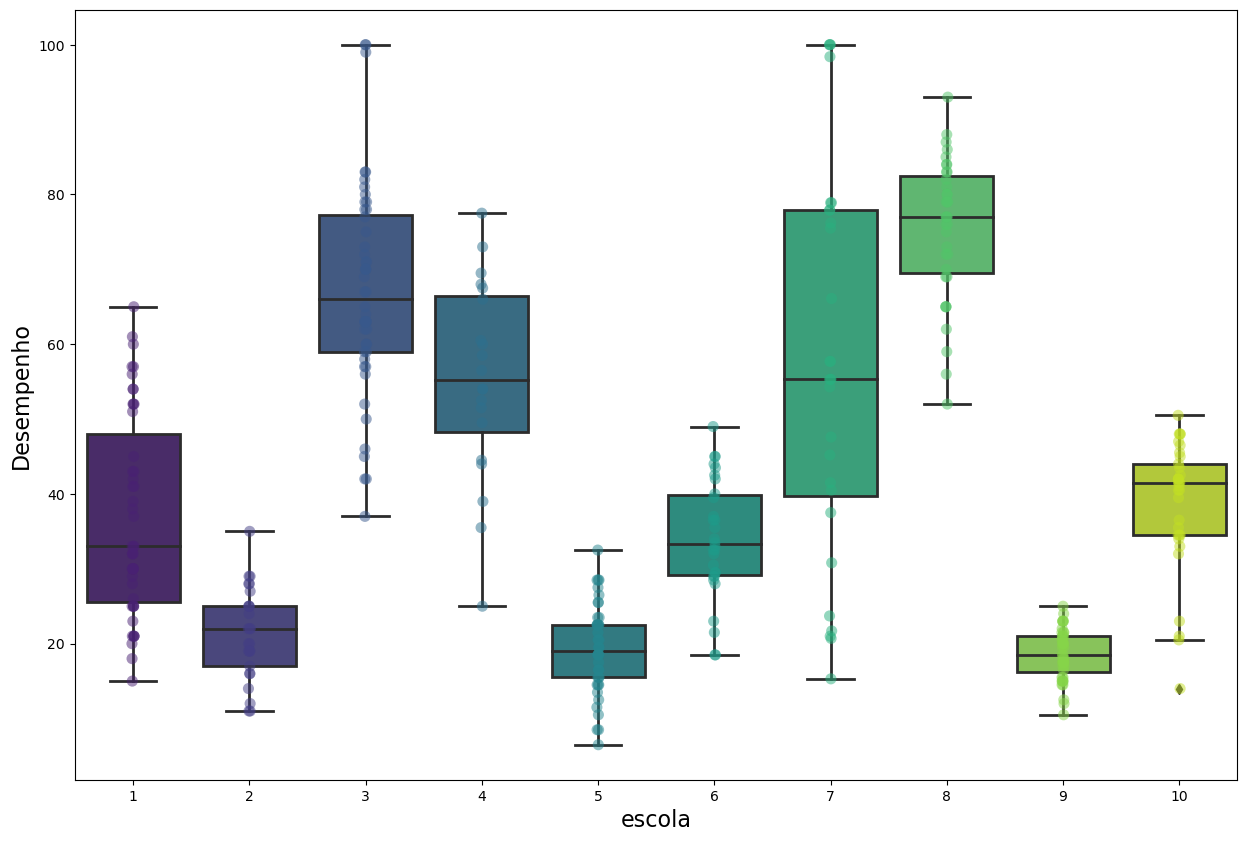

In [9]:
# Boxplot da variável dependente ('desempenho') por escola

plt.figure(figsize=(15,10))
sns.boxplot(data=df, x='escola', y='desempenho',
            linewidth=2, orient='v', palette='viridis')
sns.stripplot(data=df, x='escola', y='desempenho',
              palette='viridis', jitter=0.01, size=8, alpha=0.5)
plt.ylabel('Desempenho', fontsize=16)
plt.xlabel('escola', fontsize=16)
plt.show()


<Figure size 1500x1000 with 0 Axes>

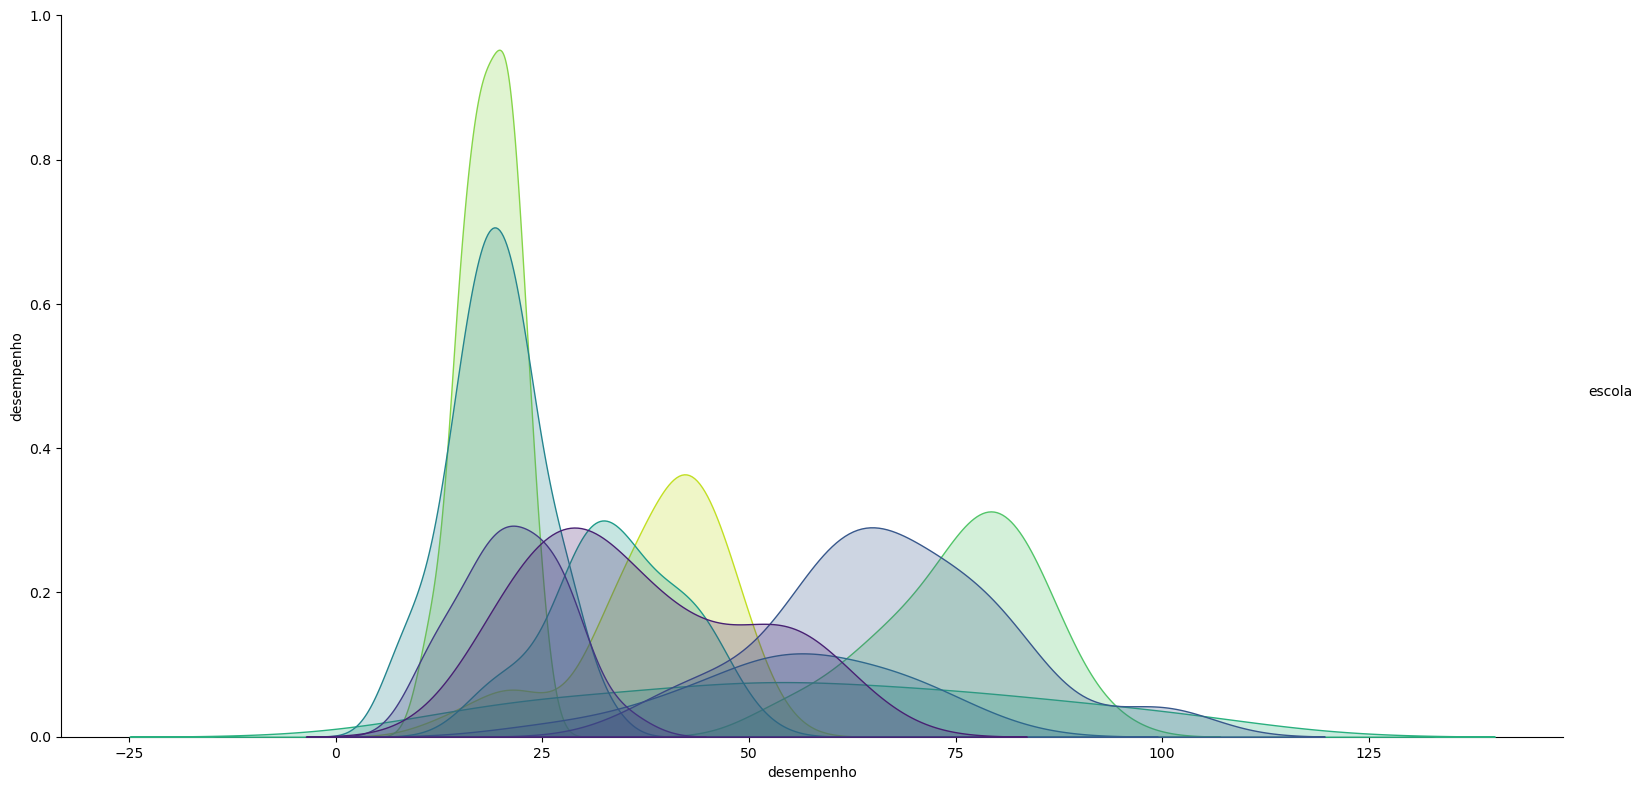

In [10]:
# Kernel density estimation (KDE) - função densidade de probabilidade da
#variável dependente ('desempenho') por escola

plt.figure(figsize=(15,10))
sns.pairplot(df[['escola','desempenho']], hue='escola', height=8,
             aspect=2, palette='viridis')
plt.xlabel('Desempenho', fontsize=17)
plt.ylabel('Frequência', fontsize=17)
plt.show()


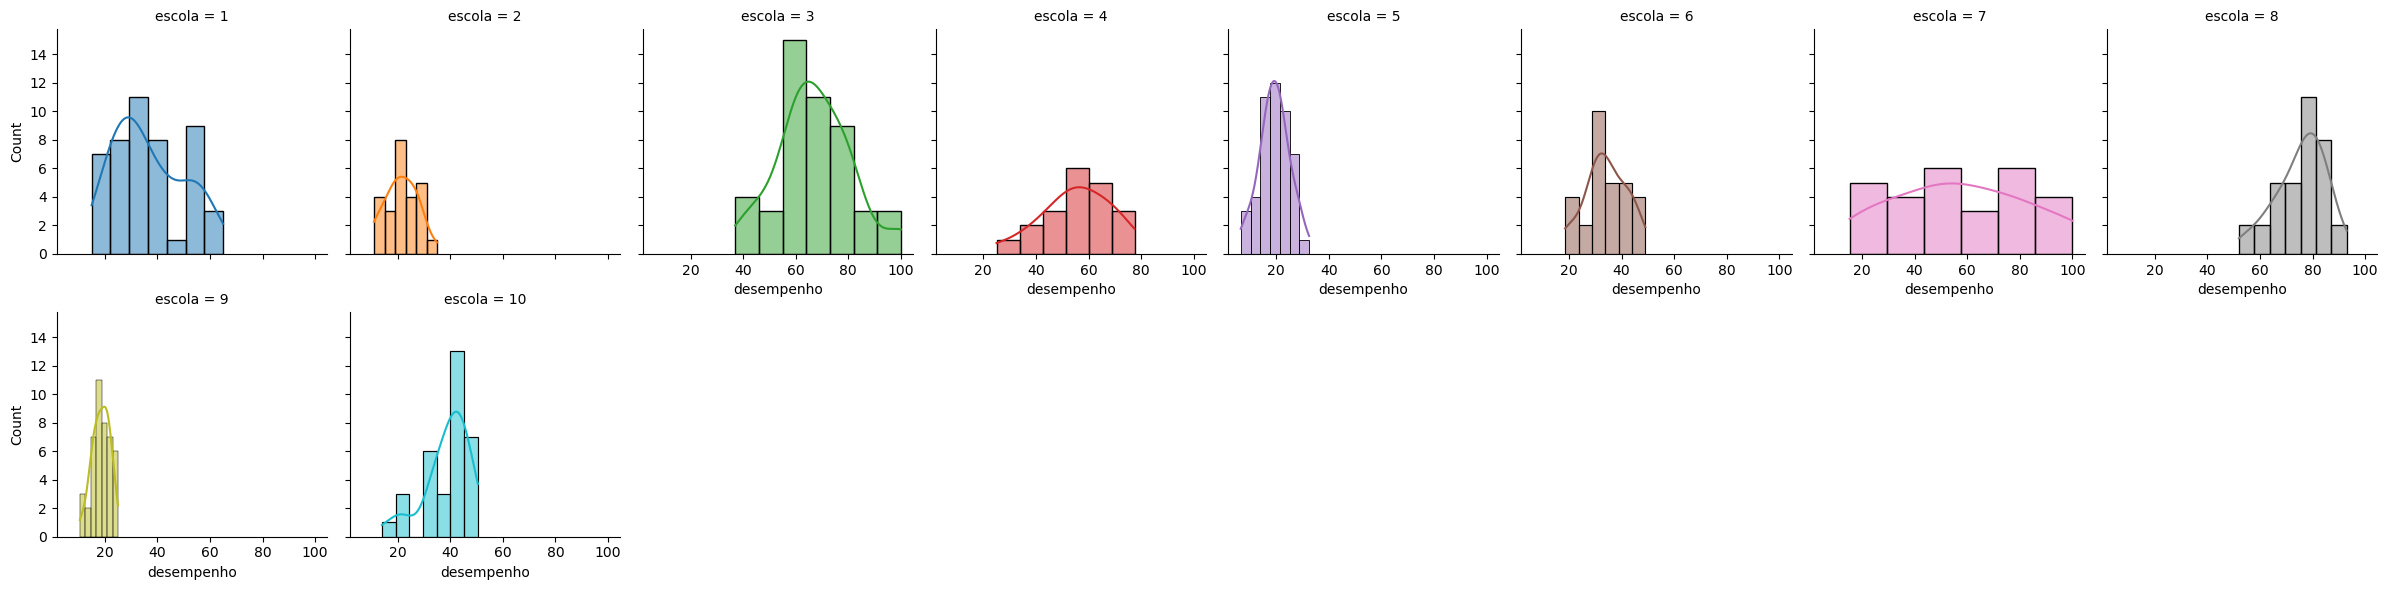

In [11]:
# Kernel density estimation (KDE) - função densidade de probabilidade da
#variável dependente ('desempenho'), com histograma e por escola separadamente
#(função 'FacetGrid' do pacote 'seaborn')

g = sns.FacetGrid(df, col='escola', col_wrap=8, hue='escola')
g.map_dataframe(sns.histplot, kde=True, x='desempenho')
plt.show()


<Figure size 1500x1000 with 0 Axes>

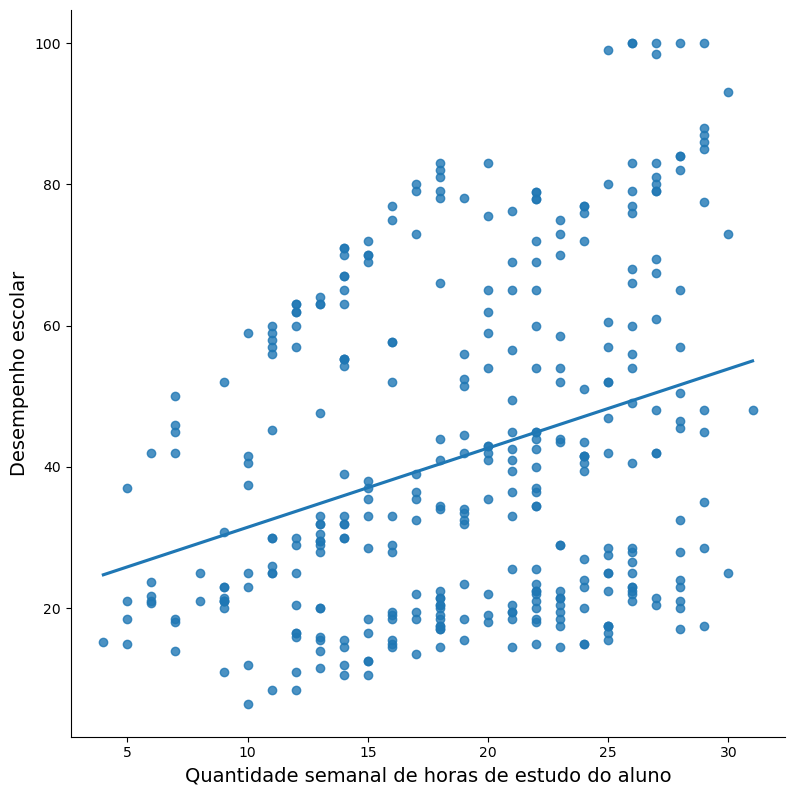

In [12]:
# Gráfico de desempenho x horas (MQO)

plt.figure(figsize=(15,10))
sns.lmplot(x='horas', y='desempenho', data=df, ci=False, height=8)
plt.ylabel('Desempenho escolar', fontsize=14)
plt.xlabel('Quantidade semanal de horas de estudo do aluno', fontsize=14)
plt.show()

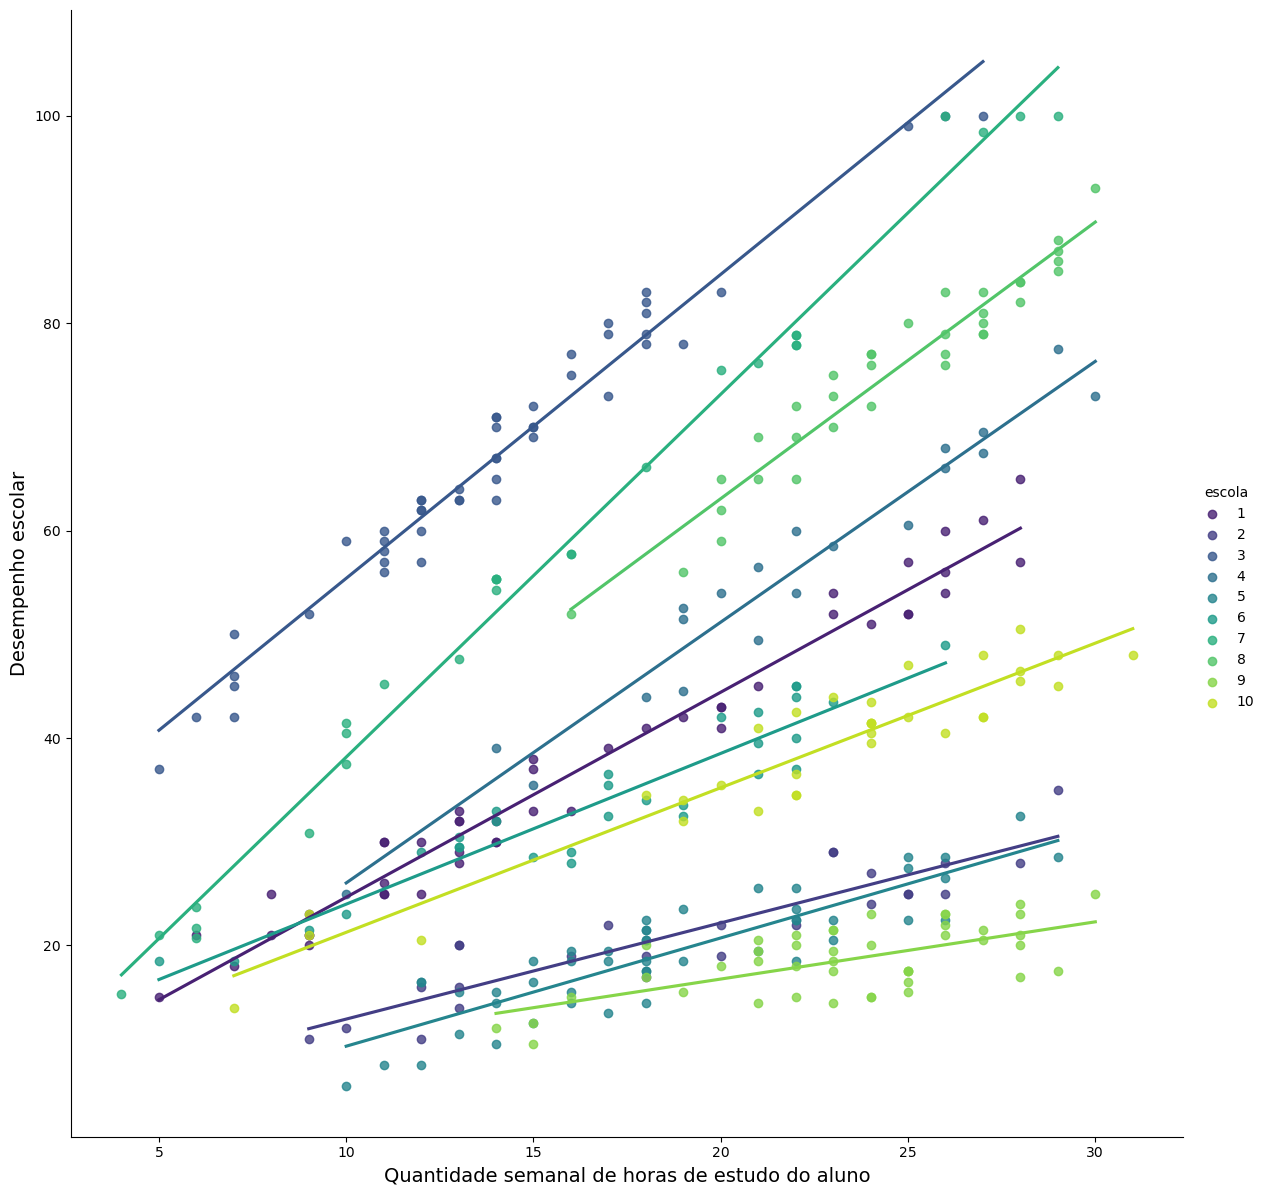

In [13]:
# Gráfico de desempenho escolar em função da variável 'horas'
# Variação entre estudantes de uma mesma escola e entre escolas diferentes
# Visualização do contexto!
# NOTE QUE A PERSPECTIVA MULTINÍVEL NATURALMENTE CONSIDERA O COMPORTAMENTO
#HETEROCEDÁSTICO NOS DADOS!

sns.lmplot(x='horas', y='desempenho', data=df, hue='escola',
           ci=False, height=12, palette='viridis')
plt.ylabel('Desempenho escolar', fontsize=14)
plt.xlabel('Quantidade semanal de horas de estudo do aluno',fontsize=14)
plt.show()

## 1.2. Estimação do modelo

### - Modelo Nulo

In [176]:
# Estimação do modelo nulo (função 'MixedLM' do pacote 'statsmodels')
modelo_nulo_hlm2 = sm.regression.mixed_linear_model.MixedLM.from_formula(formula='desempenho ~ 1',
                                           groups='escola',
                                           re_formula='1',
                                           data=df).fit()

# Parâmetros do 'modelo_nulo_hlm2'
modelo_nulo_hlm2.summary()



<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
========================================================
Model:            MixedLM Dependent Variable: desempenho
No. Observations: 358     Method:             REML      
No. Groups:       10      Scale:              142.9242  
Min. group size:  20      Log-Likelihood:     -1416.0074
Max. group size:  48      Converged:          Yes       
Mean group size:  35.8                                  
--------------------------------------------------------
               Coef.  Std.Err.   z   P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      42.387    6.468 6.553 0.000 29.709 55.065
escola Var    414.067   16.695                          
========================================================

"""

In [30]:
# Comparação com o modelo OLS nulo
# Estimação de um modelo OLS nulo
modelo_ols_nulo = sm.OLS.from_formula(formula='desempenho ~ 1',
                                      data=df).fit()

# Parâmetros do 'modelo_ols_nulo'
modelo_ols_nulo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             desempenho   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                dom, 07 mai 2023   Prob (F-statistic):                nan
Time:                        11:21:03   Log-Likelihood:                -1633.5
No. Observations:                 358   AIC:                             3269.
Df Residuals:                     357   BIC:                             3273.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     41.5542      1.228     33.852      0.000      39.140      43.968
==============================================================================
Omnibus:                       38.443   Durbin-Watson:                   0.584
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.903
Skew:                           0.626   Prob(JB):                     1.95e-07
Kurtosis:                       2.291   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
# Teste de razão de verossimilhança entre o 'modelo_nulo_hlm2' e o 'modelo_ols_nulo'

# Definição da função 'lrtest'
def lrtest(modelos):
    modelo_1 = modelos[0]
    llk_1 = modelo_1.llf
    llk_2 = modelos[1].llf
    LR_statistic = -2*(llk_1-llk_2)
    p_val = stats.chi2.sf(LR_statistic, 1)
    return round(LR_statistic,2), round(p_val,2)

# Teste de razão de verossimilhança propriamente dito
lrtest([modelo_ols_nulo, modelo_nulo_hlm2])


(434.96, 0.0)

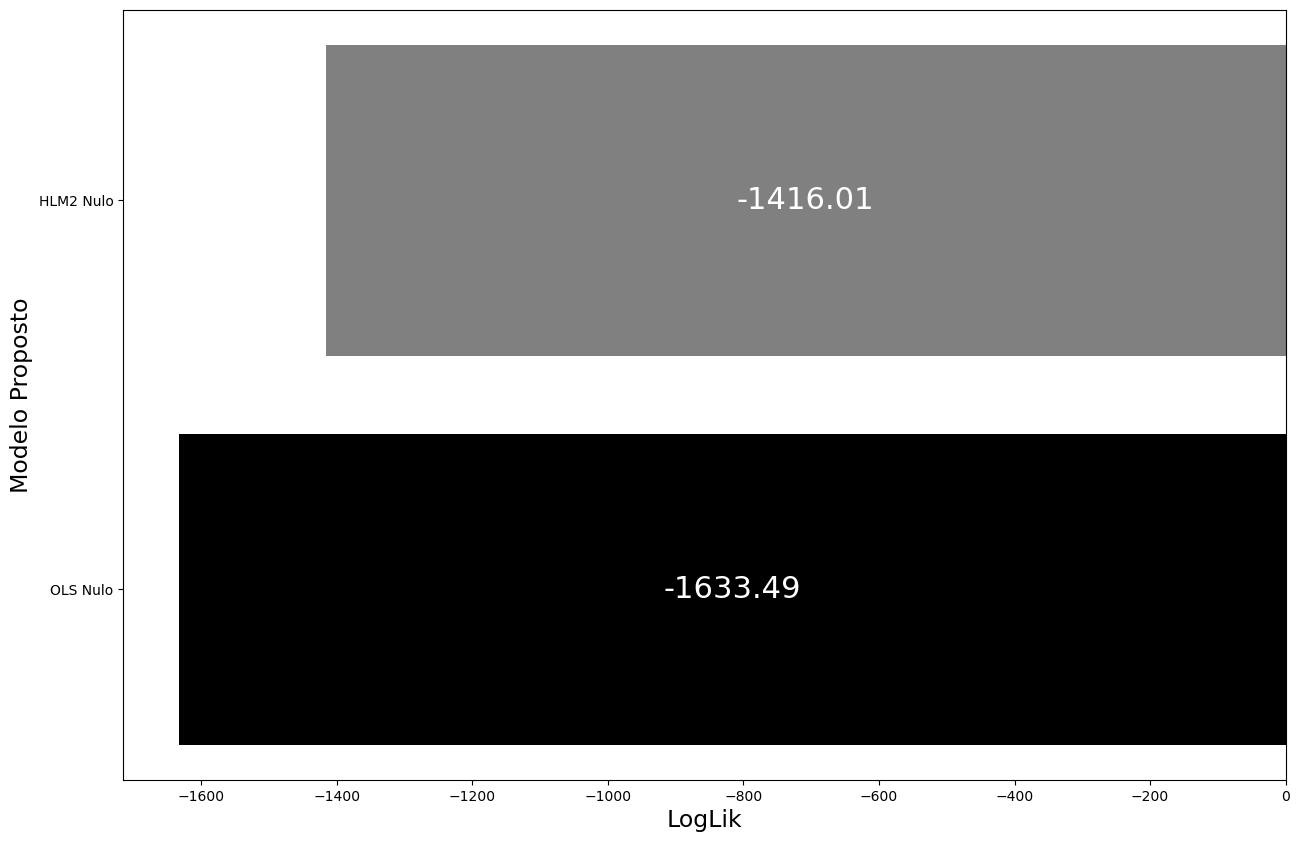

In [32]:
# Gráfico para comparação visual dos logLiks dos modelos estimados até o momento

df_llf = pd.DataFrame({'modelo':['OLS Nulo','HLM2 Nulo'],
                      'loglik':[modelo_ols_nulo.llf,modelo_nulo_hlm2.llf]})

fig, ax = plt.subplots(figsize=(15,10))

c = ['black','grey']

ax1 = ax.barh(df_llf.modelo,df_llf.loglik, color = c)
ax.bar_label(ax1, label_type='center', color='white', fontsize=22)
ax.set_ylabel("Modelo Proposto", fontsize= 17)
ax.set_xlabel("LogLik", fontsize=17)
plt.show()

### - Modelo com Interceptos Aleatórios

In [34]:
# Estimação do modelo com interceptos aleatórios
modelo_intercept_hlm2 = sm.MixedLM.from_formula(formula='desempenho ~ horas',
                                                groups='escola',
                                                re_formula='1',
                                                data=df).fit()

# Parâmetros do 'modelo_intercept_hlm2'
modelo_intercept_hlm2.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
========================================================
Model:            MixedLM Dependent Variable: desempenho
No. Observations: 358     Method:             REML      
No. Groups:       10      Scale:              31.5519   
Min. group size:  20      Log-Likelihood:     -1155.2466
Max. group size:  48      Converged:          Yes       
Mean group size:  35.8                                  
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      4.530    7.027  0.645 0.519 -9.243 18.303
horas          1.970    0.056 35.042 0.000  1.859  2.080
escola Var   481.185   40.975                           
========================================================

"""

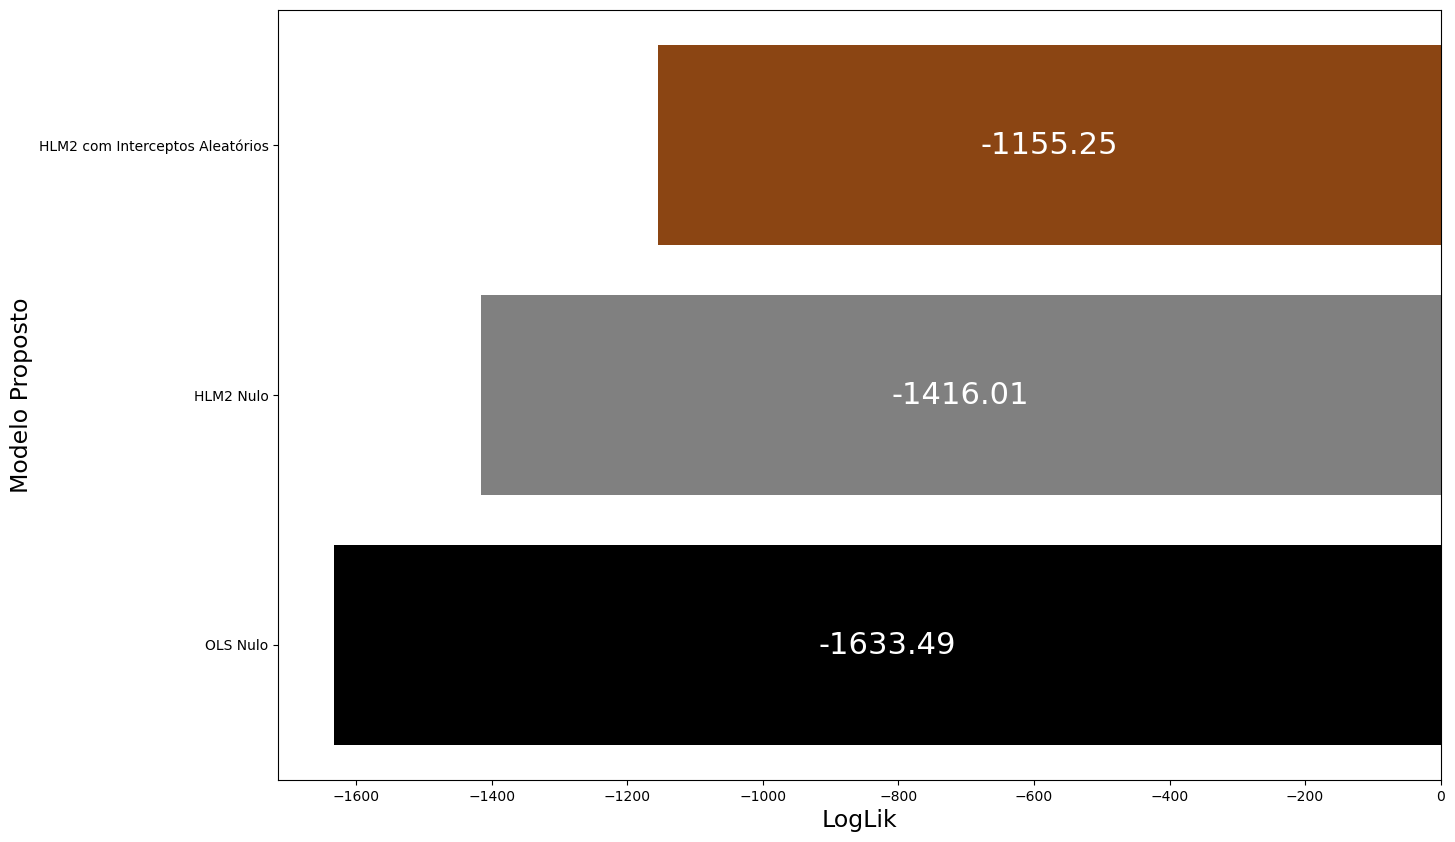

In [35]:
# Gráfico para comparação visual dos logLiks dos modelos estimados até o momento

df_llf = pd.DataFrame({'modelo':['OLS Nulo','HLM2 Nulo',
                                 'HLM2 com Interceptos Aleatórios'],
                      'loglik':[modelo_ols_nulo.llf,modelo_nulo_hlm2.llf,
                                modelo_intercept_hlm2.llf]})

fig, ax = plt.subplots(figsize=(15,10))

c = ['black','grey','saddlebrown']

ax1 = ax.barh(df_llf.modelo,df_llf.loglik, color = c)
ax.bar_label(ax1, label_type='center', color='white', fontsize=22)
ax.set_ylabel("Modelo Proposto", fontsize=17)
ax.set_xlabel("LogLik", fontsize=17)
plt.show()


### - Modelo com Interceptos e Inclinações Aleatórios

In [36]:
# Estimação do modelo com interceptos e inclinações aleatórias
modelo_intercept_inclin_hlm2 = sm.MixedLM.from_formula(formula='desempenho ~ horas',
                                                       groups='escola',
                                                       re_formula='horas',
                                                       data=df).fit()

# Parâmetros do 'modelo_intercept_inclin_hlm2'
modelo_intercept_inclin_hlm2.summary()


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  desempenho
No. Observations:   358      Method:              REML      
No. Groups:         10       Scale:               7.0497    
Min. group size:    20       Log-Likelihood:      -906.8028 
Max. group size:    48       Converged:           Yes       
Mean group size:    35.8                                    
------------------------------------------------------------
                   Coef.  Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept           7.121    2.426 2.935 0.003  2.366 11.875
horas               1.895    0.308 6.158 0.000  1.292  2.498
escola Var         55.078   10.278                          
escola x horas Cov  2.568    0.986                          
horas Var           0.938    0.170                          
============================================================

"""

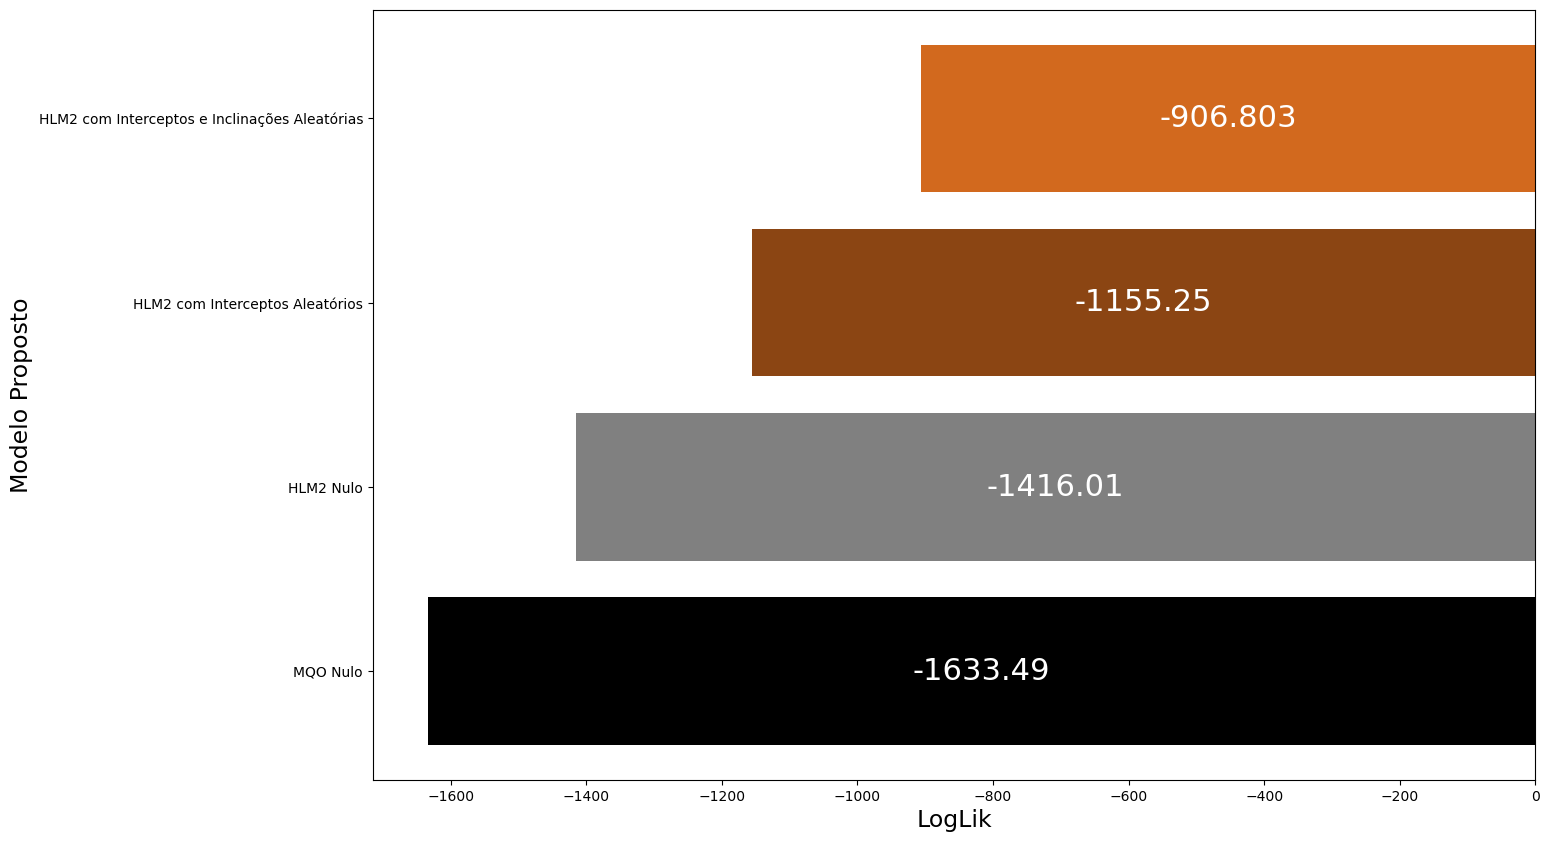

In [37]:
# Gráfico para comparação visual dos logLiks dos modelos estimados até o momento

df_llf = pd.DataFrame({'modelo':['MQO Nulo','HLM2 Nulo',
                                 'HLM2 com Interceptos Aleatórios',
                                 'HLM2 com Interceptos e Inclinações Aleatórias'],
                      'loglik':[modelo_ols_nulo.llf,modelo_nulo_hlm2.llf,
                                modelo_intercept_hlm2.llf,
                                modelo_intercept_inclin_hlm2.llf]})

fig, ax = plt.subplots(figsize=(15,10))

c = ['black','grey','saddlebrown','chocolate']

ax1 = ax.barh(df_llf.modelo,df_llf.loglik, color = c)
ax.bar_label(ax1, label_type='center', color='white', fontsize=22)
ax.set_ylabel("Modelo Proposto", fontsize=17)
ax.set_xlabel("LogLik", fontsize=17)
plt.show()


In [38]:
# Teste de razão de verossimilhança para comparar as estimações dos modelos
#com interceptos aleatórios e com interceptos e inclinações aleatórias
#(função 'lrtest' definida anteriormente)
lrtest([modelo_intercept_hlm2, modelo_intercept_inclin_hlm2])

(496.89, 0.0)

In [39]:
# Estimação do modelo final com interceptos aleatórios
modelo_final_hlm2 = sm.MixedLM.from_formula(formula='desempenho ~ horas + texp +\
                                            horas:texp',
                                            groups='escola',
                                            re_formula='horas',
                                            data=df).fit()

# Parâmetros do modelo 'modelo_final_hlm2'
modelo_final_hlm2.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:               MixedLM  Dependent Variable:  desempenho
No. Observations:    358      Method:              REML      
No. Groups:          10       Scale:               7.0443    
Min. group size:     20       Log-Likelihood:      -894.5684 
Max. group size:     48       Converged:           Yes       
Mean group size:     35.8                                    
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept          -0.850    2.999 -0.283 0.777 -6.727  5.028
horas               0.713    0.321  2.225 0.026  0.085  1.342
texp                1.585    0.487  3.256 0.001  0.631  2.540
horas:texp          0.232    0.053  4.405 0.000  0.129  0.335
escola Var         24.345    5.167                           
escola x horas Cov -2.354    0.514                           
horas Var           0.305    0.059                           
=============================================================

"""

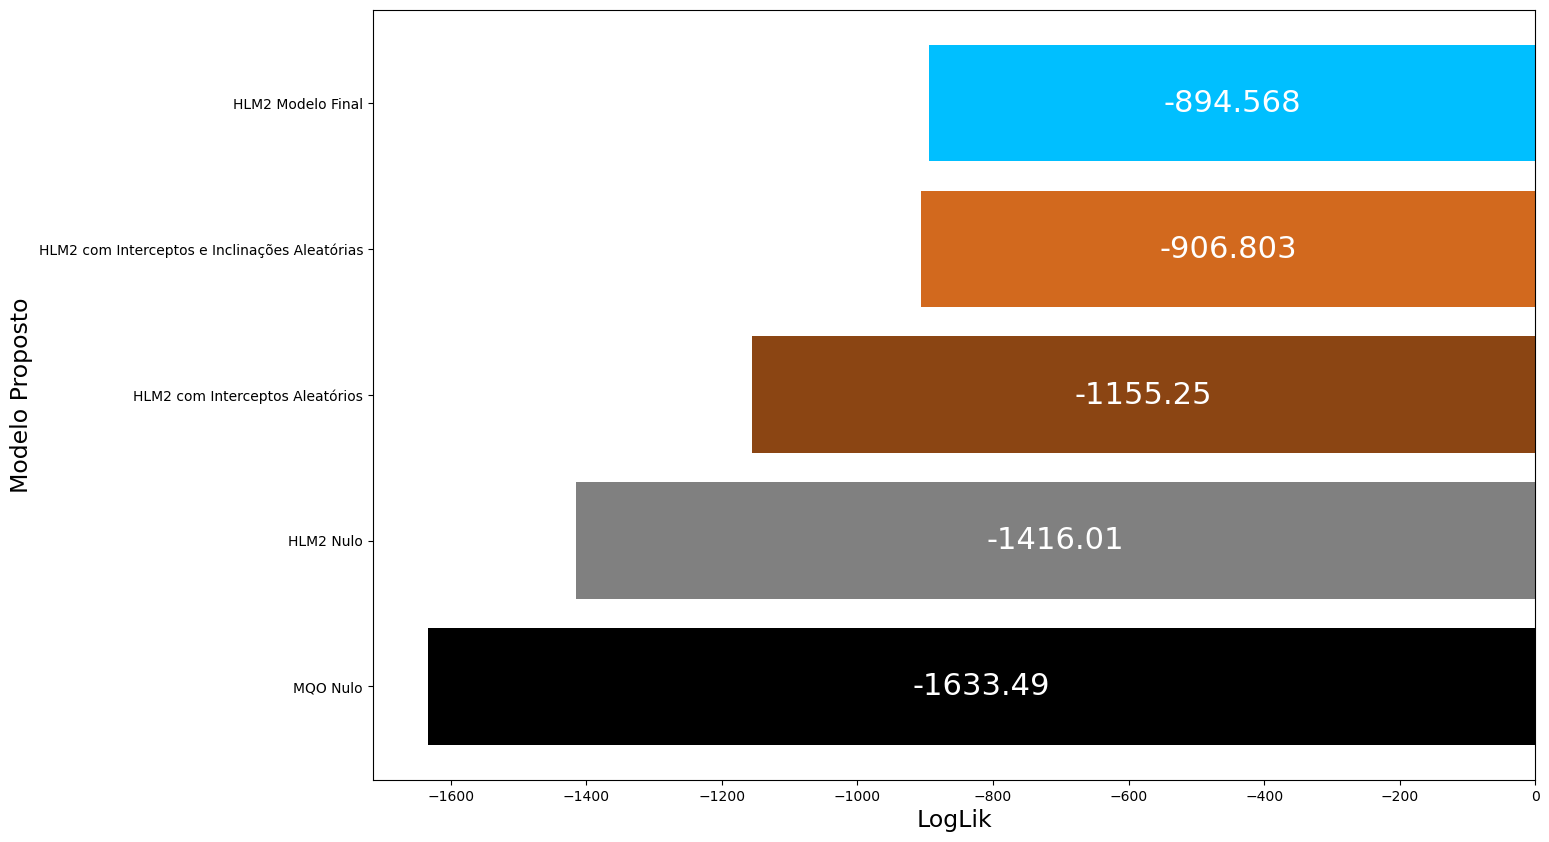

In [40]:
# Gráfico para comparação visual dos logLiks dos modelos estimados até o momento

df_llf = pd.DataFrame({'modelo':['MQO Nulo','HLM2 Nulo',
                                 'HLM2 com Interceptos Aleatórios',
                                 'HLM2 com Interceptos e Inclinações Aleatórias',
                                 'HLM2 Modelo Final'],
                      'loglik':[modelo_ols_nulo.llf,modelo_nulo_hlm2.llf,
                                modelo_intercept_hlm2.llf,
                                modelo_intercept_inclin_hlm2.llf,
                                modelo_final_hlm2.llf]})

fig, ax = plt.subplots(figsize=(15,10))

c = ['black','grey','saddlebrown','chocolate','deepskyblue']

ax1 = ax.barh(df_llf.modelo,df_llf.loglik, color = c)
ax.bar_label(ax1, label_type='center', color='white', fontsize=22)
ax.set_ylabel("Modelo Proposto", fontsize=17)
ax.set_xlabel("LogLik", fontsize=17)
plt.show()


In [27]:
# Visualização dos interceptos aleatórios por escola, para o
#'modelo_final_completo_hlm2'

pd.DataFrame(modelo_final_hlm2.random_effects)

,1,2,3,4,5,6,7,8,9,10
escola,-0.211364,1.291495,6.090772,-5.245506,-1.695358,3.864292,-8.270892,-1.363471,3.705674,1.834358
horas,0.438811,-0.278181,-0.779130,0.450368,-0.139678,0.005096,0.909171,0.217166,-0.607100,-0.216522


In [28]:
# Melhor visualização dos interceptos aleatórios por escola, para o
#'modelo_final_completo_hlm2'

efeitos_aleatorios = pd.DataFrame(modelo_final_hlm2.random_effects).T
efeitos_aleatorios = efeitos_aleatorios.rename(columns = {'escola':'u0j'})
efeitos_aleatorios = efeitos_aleatorios.reset_index().rename(columns={'index': 'escola'})
efeitos_aleatorios

,escola,u0j,horas
0,1,-0.211364,0.438811
1,2,1.291495,-0.278181
2,3,6.090772,-0.779130
3,4,-5.245506,0.450368
4,5,-1.695358,-0.139678
5,6,3.864292,0.005096
6,7,-8.270892,0.909171
7,8,-1.363471,0.217166
8,9,3.705674,-0.607100
9,10,1.834358,-0.216522


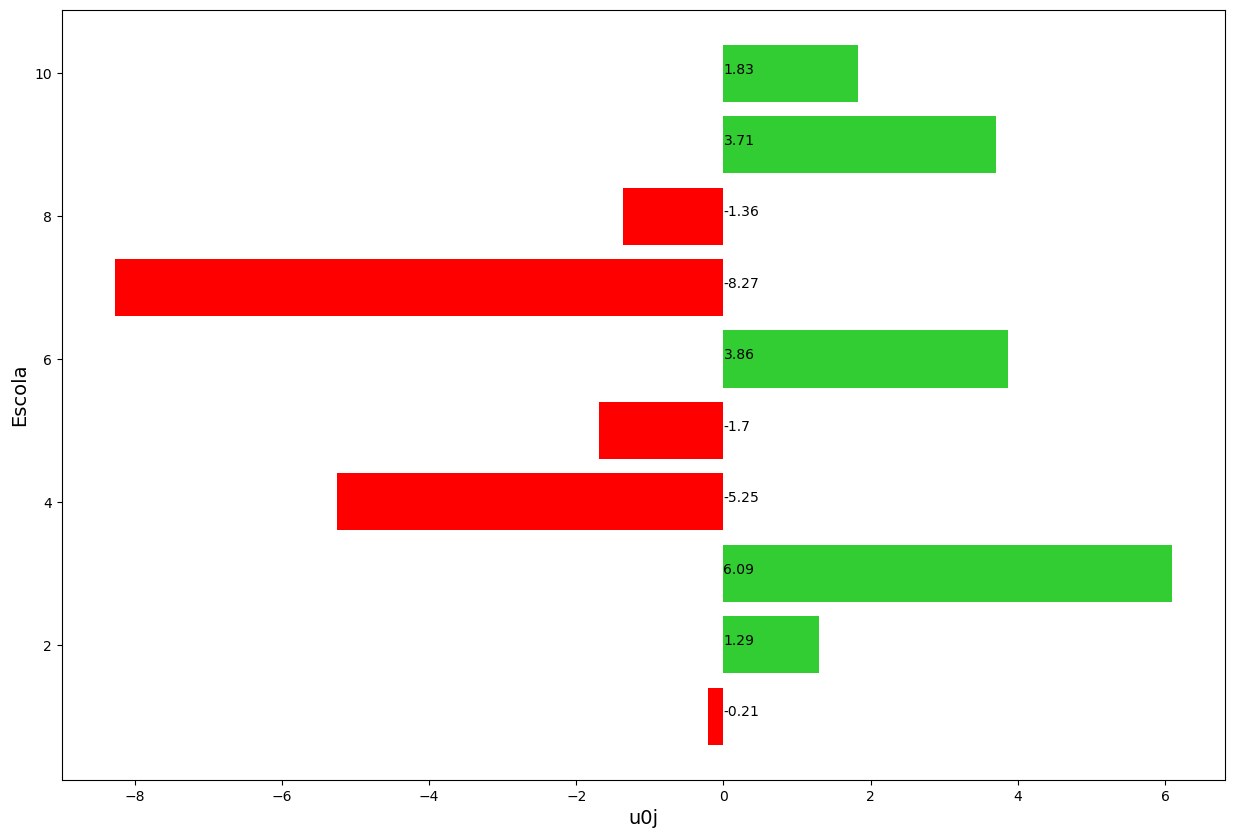

In [29]:
# Gráfico para visualização do comportamento dos valores de u0j, ou seja,
#dos interceptos aleatórios por escola

colors = ['limegreen' if x>0 else 'red' for x in efeitos_aleatorios['u0j']]

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(0, point['y'], str(round(point['x'],2)),fontsize=10)

plt.figure(figsize=(15,10))
plt.barh(efeitos_aleatorios['escola'], efeitos_aleatorios['u0j'], color=colors)

label_point(x = efeitos_aleatorios['u0j'],
            y = efeitos_aleatorios['escola'],
            val = efeitos_aleatorios['u0j'],
            ax = plt.gca()) 
plt.ylabel('Escola', fontsize=14)
plt.xlabel('u0j', fontsize=14)
plt.show()


In [30]:
# Visualização dos fitted values do 'modelo_final_hlm2', por estudante
#e por escola

fixed = modelo_final_hlm2.predict(df.drop(columns=['desempenho']))

df['predict.fixed'] = fixed
df['predict.escola'] = modelo_final_hlm2.fittedvalues
df['rij'] = modelo_final_hlm2.resid
df

,estudante,escola,desempenho,horas,texp,predict.fixed,predict.escola,rij
0,1,1,25.0,11,3.6,21.885819,26.501371,-1.501371
1,2,1,52.0,23,3.6,40.462363,50.343641,1.656359
2,3,1,52.0,25,3.6,43.558453,54.317353,-2.317353
3,4,1,30.0,14,3.6,26.529955,32.461938,-2.461938
4,5,1,51.0,24,3.6,42.010408,52.330497,-1.330497
...,...,...,...,...,...,...,...,...
353,354,10,46.5,28,3.9,50.625529,46.397262,0.102738
354,355,10,21.0,9,3.9,19.891243,19.776900,1.223100
355,356,10,42.0,27,3.9,49.007935,44.996191,-2.996191
356,357,10,14.0,7,3.9,16.656055,16.974757,-2.974757


In [31]:
#%%
# Elaboração de previsões para o 'modelo_final_completo_hlm2':
# Exemplo: Quais os valores previstos de desempenho escolar, para dado
#aluno que estuda na escola "1", sabendo-se que estuda 11 horas por semana e
#que a escola oferece tempo médio de experiência de seus professores igual a
#3,6 anos?

modelo_final_hlm2.predict(pd.DataFrame({'horas':[11],
                                        'texp':[3.6],
                                        'escola':['1']}))



0    21.885819
dtype: float64

In [32]:
# O resultado obtido por meio da função 'predict' só considera efeitos fixos.
# Criação do objeto 'resultado_fixo' apenas com o efeito fixo
resultado_fixo = modelo_final_hlm2.predict(pd.DataFrame({'horas':[11],
                                                         'texp':[3.6],
                                                         'escola':['1']}))

# A função 'predict' não considera os efeitos aleatórios de intercepto por
#'escola'. Neste sentido, precisamos adicioná-los a partir dos parâmetros do
#'modelo_final_hlm2', conforme segue.

In [33]:
# Efeitos aleatórios de intercepto por 'escola'
pd.DataFrame(modelo_final_hlm2.random_effects)

,1,2,3,4,5,6,7,8,9,10
escola,-0.211364,1.291495,6.090772,-5.245506,-1.695358,3.864292,-8.270892,-1.363471,3.705674,1.834358
horas,0.438811,-0.278181,-0.779130,0.450368,-0.139678,0.005096,0.909171,0.217166,-0.607100,-0.216522


In [34]:
# Criação do objeto 'resultado_aleat_escola1' com o efeito aleatório de intercepto
#da escola 1
resultado_aleat_escola1 = modelo_final_hlm2.random_effects[1]
resultado_aleat_escola1


escola   -0.211364
horas     0.438811
dtype: float64

In [35]:
# Predição completa para o enunciado anterior, com efeitos fixos e aleatórios
#para a escola 1
resultado_total = resultado_fixo.iloc[0] + resultado_aleat_escola1.iloc[0]
resultado_total


21.674454355661943

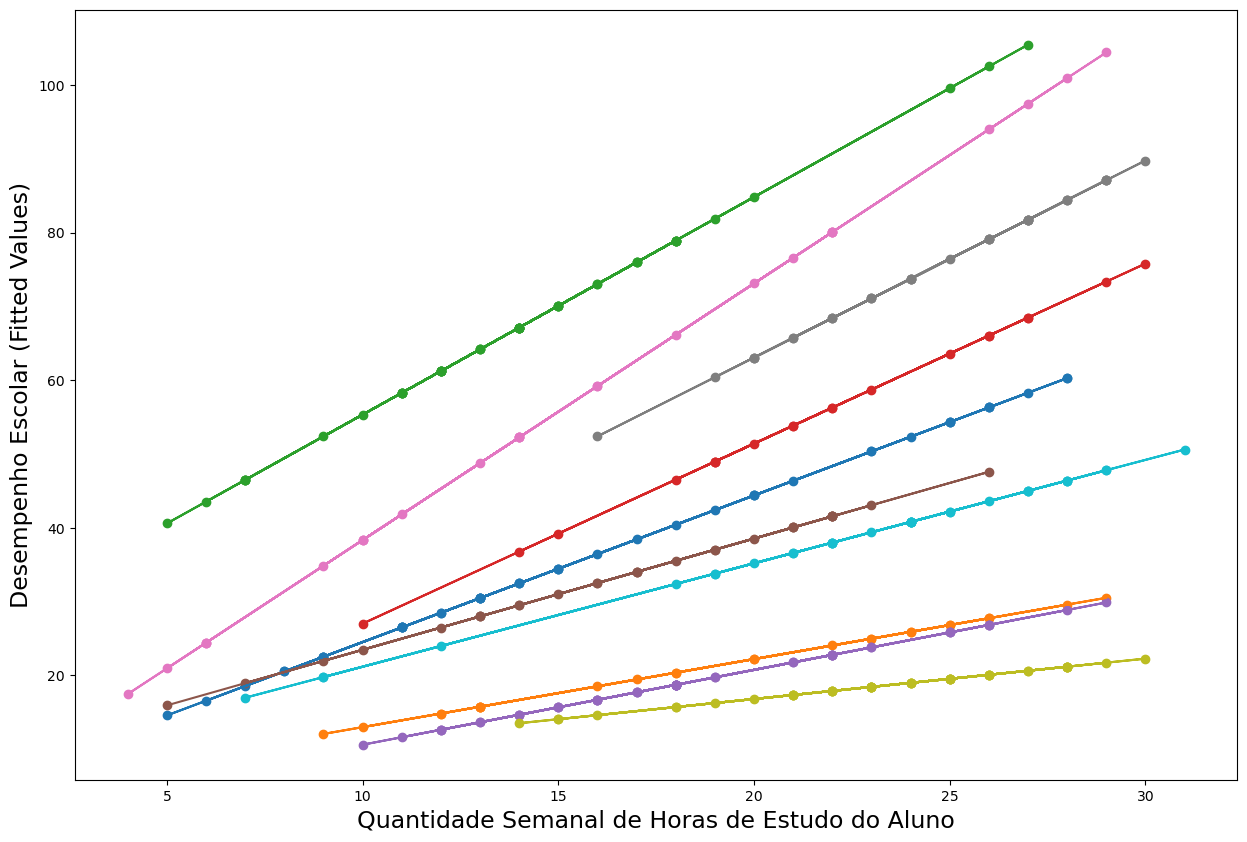

In [36]:
# Gráfico com valores previstos do desempenho escolar em função da variável 'horas'
#para o 'modelo_final_completo_hlm2'

plt.figure(figsize=(15,10))
escolas = df.escola.unique()
[plt.plot(df[df['escola']==escola].horas,
          df[df['escola']==escola]['predict.escola']) for escola in escolas]
[plt.scatter(df[df['escola']==escola].horas,
             df[df['escola']==escola]['predict.escola']) for escola in escolas]
plt.ylabel('Desempenho Escolar (Fitted Values)', fontsize=17)
plt.xlabel('Quantidade Semanal de Horas de Estudo do Aluno', fontsize=17)
plt.show()